In [4]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
folder = "kaggle-cardio/"
cardio_file = "cardio_train.csv"

df_cardio = pd.read_csv(f"{folder}{cardio_file}", sep = ";")

df_cardio["bmi"] = df_cardio["weight"] / (df_cardio["height"] / 100) ** 2

def plot_column(df, col_name, min, max):
    return df[(df[col_name] > min) & (df[col_name] < max)]

df_cardio = plot_column(df_cardio, "bmi", min = 15, max = 50)

df_cardio["bmi_category"] = pd.cut(
    df_cardio["bmi"], 
    bins = [0, 25, 30, 35, 40, 1000], 
    labels = ["Normal", "Overweight", "Obese (Class I)", "Obese (Class II)", "Obese (Class III)"], 
    right = False
)

df_cardio = plot_column(df_cardio, "ap_hi", min = 75, max = 200)

df_cardio = plot_column(df_cardio, "ap_lo", min = 50, max = 150)

In [5]:
def ap_categorizer(hi, lo):
    '''ap_categorizer() takes blood two pressure values as arguments and returns the blood pressure category'''

    if hi >= 180 or lo >= 120: return "Hypertension crisis"
    if hi >= 140 or lo >= 90: return "Stage 2 hypertension"
    if hi < 120 and lo < 80: return "Healthy"
    if hi < 130 and lo < 80: return "Elevated"
    return "Stage 1 hypertension"

df_cardio["ap_category"] = df_cardio.apply(lambda x: ap_categorizer(x["ap_hi"], x["ap_lo"]), axis = 1).astype("category")

In [6]:
df_cardio_first = df_cardio.drop(["ap_hi", "ap_lo", "height", "weight", "bmi"], axis = 1)
df_cardio_first = pd.get_dummies(df_cardio_first, columns = ["bmi_category", "ap_category", "gender"], drop_first = True)

df_cardio_second = df_cardio.drop(["bmi_category", "ap_category", "height", "weight"], axis = 1)
df_cardio_second = pd.get_dummies(df_cardio_second, columns = ["gender"], drop_first = True)

df_cardio_second.head()

,id,age,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,gender_2
0,0,18393,110,80,1,1,0,0,1,0,21.967120,1
1,1,20228,140,90,3,1,0,0,1,1,34.927679,0
2,2,18857,130,70,3,1,0,0,0,1,23.507805,0
3,3,17623,150,100,1,1,0,0,1,1,28.710479,1
4,4,17474,100,60,1,1,0,0,0,0,23.011177,0


In [7]:
def tvt_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.5, random_state = 42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

    return X_train, X_val, X_test, y_train, y_val, y_test

datasets = {}

X_train, X_val, X_test, y_train, y_val, y_test = tvt_split(df_cardio_first.drop(["id", "cardio"], axis = 1), df_cardio_first["cardio"])

X_train, X_val, X_test, y_train, y_val, y_test = tvt_split(df_cardio_second.drop(["id", "cardio"], axis = 1), df_cardio_second["cardio"])

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((34130, 10), (17065, 10), (17065, 10), (34130,), (17065,), (17065,))

In [8]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

In [9]:
from evolutionary_algos import VectorizedEvoClassifier

classifier = VectorizedEvoClassifier(n = 100, hidden_layers = [6], activation = "relu", random_state = 42)
classifier.fit(scaled_X_train, y_train, epochs = 100, validation_data = (scaled_X_val, y_val), verbose = 1)

Epoch 0 - loss: 0.38444775748307275 - val_loss: 0.38199318477311384


/Users/dp/Documents/GitHub/Deep-learning-Daniel-Petersson/evolutionary_algos.py:295: RuntimeWarning: overflow encountered in exp
  self.output_activation_function = lambda x: 1 / (1 + np.exp(-x))


Epoch 1 - loss: 0.35937322433431157 - val_loss: 0.35181214655698634
Epoch 2 - loss: 0.34875292520222206 - val_loss: 0.3421079122757956
Epoch 3 - loss: 0.33514800531373207 - val_loss: 0.3315221107216767
Epoch 5 - loss: 0.3266702297160943 - val_loss: 0.3264258931280659
Epoch 6 - loss: 0.31788460113894307 - val_loss: 0.3093505522134056
Epoch 11 - loss: 0.3146049979339621 - val_loss: 0.3070462917996588
Epoch 13 - loss: 0.31300097584301456 - val_loss: 0.30474769704415267
Epoch 14 - loss: 0.31182453382696385 - val_loss: 0.3040000334544755
Epoch 15 - loss: 0.3114278726047718 - val_loss: 0.30358025588662146
Epoch 16 - loss: 0.31013958809390957 - val_loss: 0.30254859764938147
Epoch 17 - loss: 0.3098684584964267 - val_loss: 0.3030865816568698
Epoch 18 - loss: 0.30935958324923646 - val_loss: 0.30268612233945186
Epoch 19 - loss: 0.30668870566424145 - val_loss: 0.2994062774063255
Epoch 21 - loss: 0.3057199334234784 - val_loss: 0.2979441591549274
Epoch 23 - loss: 0.3051052805030046 - val_loss: 0.297

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      8683
           1       0.74      0.68      0.71      8382

    accuracy                           0.72     17065
   macro avg       0.73      0.72      0.72     17065
weighted avg       0.73      0.72      0.72     17065



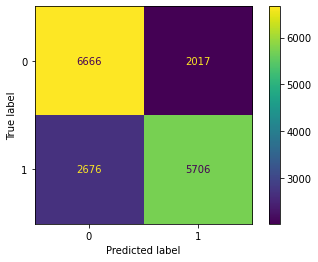

In [11]:
y_pred = classifier.predict(scaled_X_test)
y_pred = (y_pred > 0.5) * 1

print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()